SID: 480564766

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import csv

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV
from sklearn.model_selection import KFold, cross_val_score, LeaveOneOut
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

Load the train dataset and set as train 


In [2]:
train = pd.read_csv('train.csv')


MSSubClass converted to a string as it is categorical variable 

Set string to be all categorical variables in train. Replace all NaN values with 'None'.

Create Dummy variable using the data subset string. Set the new data set as dummy_string


In [3]:
train['MSSubClass'] = train['MSSubClass'].apply(str)

string = train.select_dtypes('object')
string = string.replace(np.nan,'None')
dummy_string = pd.get_dummies(string)


Set num to be all numerical variables in train

Replace all NaN values with 0

join num and dummy_string to create modified version of the training dataset. Set this new dataset as x


In [4]:
num = train.select_dtypes('number')
num = num.replace(np.nan, 0)

x = pd.concat([dummy_string,num], axis=1)


Sort all variables in descending order by correlation with Saleprice. Set this dataset as x_corr

Keep all variables that are sufficiently correlated with Saleprice using 0.4 as a threshold. Set this as x_reduced 


In [5]:
x_corr = abs(x.corr()).sort_values(by='SalePrice', ascending=False)[['SalePrice']]

x_reduced = x[x_corr[x_corr['SalePrice']>0.4].index.tolist()]


Remove any outlier data that has x_reduced.GrLivArea >= 4500 from x_reduced 

remove SalePrice from x_reduced


In [6]:
x_reduced = x_reduced[x_reduced.GrLivArea < 4500]

del x_reduced['SalePrice']


Remove any outlier data that has x_reduced.GrLivArea >= 4500 from original training dataset. Set it to sale_log

take the log transformation of SalePrice. From trial and error, this improves the accuracy of the implemented methods. From the graph below, log transformation normaly distributes SalePrice. Previously SalePrice is skewed to the right 

Reshape the SalePrice for prediction. Set as y_train


<AxesSubplot:>

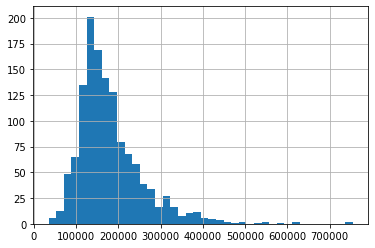

In [7]:
sale_log = train[train.GrLivArea < 4500]

sale_log = np.log1p(sale_log["SalePrice"])

y_train = sale_log.values.reshape(-1,1)

train["SalePrice"].hist(bins = 40)

<AxesSubplot:>

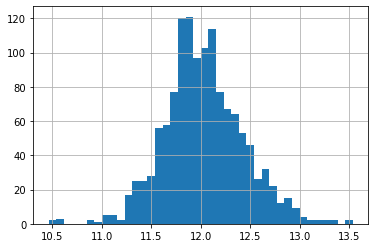

In [8]:
sale_log.hist(bins = 40)

Standardizing x variables(i.e. x_reduced dataset) with the inbuilt python packages. Calling the Standardized version Z_train

In [9]:
ss = StandardScaler()

Z_train = ss.fit_transform(x_reduced)

Z_train = pd.DataFrame(ss.transform(x_reduced), columns=x_reduced.columns)

Ridge regression using cross validation to find an optimal alpha with the inbuilt packages provided by python

RidgeCV will find an optimal alpha from r_alphas using neg_mean_squared_error for scoring

fit the model using Z_train and y_train, set this as ridge

(For this project, Lasso regression is not used as some manual model selection was performed prior. The most relevant predictors are already chosen)

In [10]:
r_alphas = np.logspace(0, 5, 100)

ridge = RidgeCV(alphas = r_alphas, scoring='neg_mean_squared_error')

ridge = ridge.fit(Z_train, y_train)

Linear Regression with the inbuilt python package using Z_traina and y_train. Set as es

In [11]:
es = LinearRegression().fit(Z_train, y_train)

Y_pred = es.predict(Z_train)

Load the testing data set. Set as test

In [12]:
test = pd.read_csv('test.csv')

MSSubClass converted to a string as it is a categorical variable

Set test_string to be all categorical variables in test. Replace all NaN values with 'None'.

Create Dummy variable using the data subset string. Set the new data set as dummy_test

In [13]:
test['MSSubClass'] = test['MSSubClass'].apply(str)

test_string = test.select_dtypes('object')
test_string  = test_string.replace(np.nan,'None')
dummy_test = pd.get_dummies(test_string)


Set test_num to be all numerical variables in test dataset

Replace all NaN values with 0

join test_num and dummy_test to create modified version of the testing dataset. Set this new dataset as x_test

In [14]:
test_num = test.select_dtypes('number')
test_num = test_num.replace(np.nan, 0)

x_test = pd.concat([dummy_test,test_num], axis=1)

Set x_test to only include the same predictors that were selected with the manual model selection prior when creating x_reduced

In [15]:
x_test = x_test[['OverallQual','GrLivArea','GarageCars','GarageArea','TotalBsmtSF','1stFlrSF','ExterQual_TA',
                  'BsmtQual_Ex','FullBath','TotRmsAbvGrd','KitchenQual_TA','YearBuilt','YearRemodAdd','KitchenQual_Ex',
                  'Foundation_PConc','MasVnrArea','FireplaceQu_None','Fireplaces','ExterQual_Ex','ExterQual_Gd',
                  'BsmtQual_TA','HeatingQC_Ex','BsmtFinType1_GLQ','GarageFinish_Fin','Neighborhood_NridgHt',
                  'GarageFinish_Unf']]

Standardizing x variables(i.e. x_test dataset) with the inbuilt python packages. Calling the Standardized version Z_test

In [16]:
Z_test = ss.fit_transform(x_test)

Z_test = pd.DataFrame(ss.transform(x_test), columns=x_test.columns)

Perform predictions using the prior ridge regression and linear regression using Z_test. Set as y_ridge for ridge regression and
y_ols for linear regression

In [17]:
y_ridge = ridge.predict(Z_test)

y_ols = es.predict(Z_test)

Perform k- fold cross validation using 10 folds to compute mean absolute error from the predictions using ridge regression and linear regression

Set the mean absolute error from the scores from prediction using ridge as ridge_e and the mean absolute error from the scores from prediction using linear regression as ols_e.

In [18]:
model = LinearRegression()

cross = KFold(n_splits = 10, random_state = 5, shuffle = True)

ridge_scores = cross_val_score(model, Z_test, y_ridge, scoring = 'neg_mean_squared_error',cv = cross)
ols_scores = cross_val_score(model, Z_test, y_ols, scoring = 'neg_mean_squared_error',cv = cross)

ridge_e = np.mean(np.abs(ridge_scores))
ols_e = np.mean(np.abs(ols_scores))

Using if else conditions find which mean absolute error was lower. The method which has the lowest error is printed with its associated error

In this case, Ridge Regression is printed and so will be chosen to predict Saleprices

In [19]:
if (ridge_e < ols_e):
    print("Ridge Regression: " + str(ridge_e))
else:
    print("Linear Regression: " + str(ols_e))

Ridge Regression: 1.4199496293978213e-30


Small program to write to an excel file submission.csv, with the index and the prediction

prediction obtained by calculating the inverse log of each y_ridge to get the predicted saleprice of each house id

In [20]:
start_id = 1301
count = 0
    
with open('submission.csv', 'w', newline= '' ) as myfile:
    wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
    wr.writerow(['Id','SalePrice'])
    
    for i in y_ridge:
        wr.writerow([start_id+count, np.expm1(y_ridge[count][0])])
        count+=1
        